This kernel uses data from [Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/overview)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.utils.data
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


First we import data from csv file and split it into 3 groups: training, testing, validation

In [2]:
# read data
all_data = pd.read_csv("fer2013/train.csv")

In [3]:
# split to 3 parts
groups = [g for _, g in all_data.groupby('Usage')]
training_data = groups[2]
testing_data = groups[1]
validation_data = groups[0]

In [4]:
res = np.array([np.fromstring(image, np.uint8, sep=' ') for image in testing_data['pixels']])
res = res.reshape(res.shape[0], 48, 48)
res.shape

(3589, 48, 48)

Second, we process groups to transform Dataframes to DataLoader and to reshape images array from 1D to 2D:

In [5]:
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
def make_dataloader(data, batch_size, shuffle):
    images, labels = data['pixels'], data['emotion']
    images = np.array([np.fromstring(image, np.uint8, sep=' ') for image in images])
    print('image.shape 1:', images.shape)
    images = images.reshape(images.shape[0], 48, 48)
    print('image.shape 2:', images.shape)
    dataset = torch.utils.data.TensorDataset(torch.Tensor(images), torch.Tensor(np.array(labels)).int())
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = make_dataloader(training_data, 100, True)
test_loader = make_dataloader(testing_data, 100, True)
valid_loader = make_dataloader(validation_data, 100, False)



image.shape 1: (28709, 2304)
image.shape 2: (28709, 48, 48)
image.shape 1: (3589, 2304)
image.shape 2: (3589, 48, 48)
image.shape 1: (3589, 2304)
image.shape 2: (3589, 48, 48)


Let's look at data:

Sad


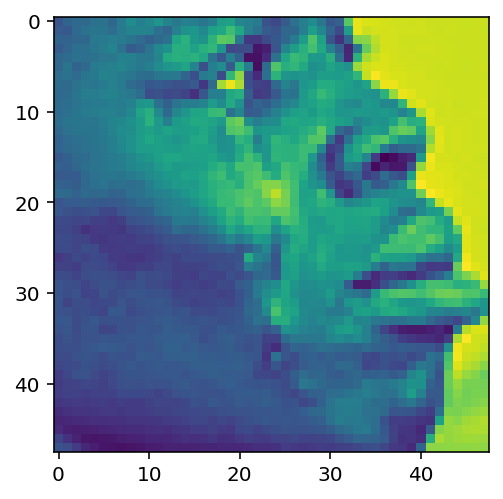

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(label_names[labels[1]])
plt.imshow(images[1]);

In [7]:
#---------------------------------------- MODEL ----------------------------------------------
# data understanding
# - shape
print(training_data.shape)
print(testing_data.shape)

(28709, 3)
(3589, 3)


In [8]:
# - header
training_data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
from torch import nn
from collections import OrderedDict
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [10]:
model = nn.Sequential(OrderedDict([
    ('fc1',  nn.Linear(2304, 1024)),
    ('relu', nn.ReLU()),
    ('drop', nn.Dropout(p=0.2)),
    ('fc2',  nn.Linear(1024, 512)),
    ('relu', nn.ReLU()),
    ('fc3',  nn.Linear(512, 128)),
    ('relu', nn.ReLU()),
    ('fc4',  nn.Linear(128, 7)),
    ('output', nn.Softmax(dim=1))
]))

In [11]:
# *********** Train the model **********
import tensorflow as tf
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
   
model.to(device)

epochs = 150
step = 0

preds = []
for e in range(epochs):
    print('Epoch:', e+1)
    running_loss = 0
    trainloader = train_loader

    for imgs, labels in trainloader:
        lbs = torch.tensor(labels, dtype=torch.long)
        step += 1
        imgs = imgs.view(imgs.shape[0], -1)
        imgs, lbs = imgs.to(device), lbs.to(device)

        optimizer.zero_grad()

        logps = model(imgs)
        loss = criterion(logps, lbs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        with torch.no_grad():
            model.eval()
            test_loss = 0
            accuracy  = 0

            for imgs, labels in test_loader:
                lbs = torch.tensor(labels, dtype=torch.long)
                imgs = imgs.view(imgs.shape[0], -1)
                imgs, lbs = imgs.to(device), lbs.to(device)

                logps = model(imgs)
                loss = criterion(logps, lbs)
                test_loss += loss.item()

                ps = torch.exp(logps)
                top_ps, top_class = ps.topk(1, dim=1)
                equality = top_class == lbs.view(*top_class.shape)
                accuracy += torch.mean(equality.type(torch.FloatTensor)).item()

                preds.append(top_class.cpu().flatten())
        model.train()

        print( 'Training loss:', running_loss/(epochs) )
        print( 'Test loss:', test_loss/len(test_loader) )
        print( 'Accuracy:', accuracy/len(test_loader) )


Epoch: 1


C:\Users\elena\.conda\envs\pysyft\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\elena\.conda\envs\pysyft\lib\site-packages\ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training loss: -0.40370660747090975
Test loss: -0.24884207215574053
Accuracy: 0.24884207215574053
Epoch: 2
Training loss: -0.4216814802090327
Test loss: -0.24829275864693853
Accuracy: 0.24829275864693853
Epoch: 3
Training loss: -0.41568148136138916
Test loss: -0.2484644196099705
Accuracy: 0.2484644196099705
Epoch: 4
Training loss: -0.41862222214539846
Test loss: -0.24843008485105303
Accuracy: 0.24843008485105303
Epoch: 5
Training loss: -0.42268148019909857
Test loss: -0.24856741602222124
Accuracy: 0.24856741602222124
Epoch: 6
Training loss: -0.42448888808488844
Test loss: -0.2483957554731104
Accuracy: 0.2483957554731104
Epoch: 7


KeyboardInterrupt: 

In [ ]:
# ------------------------------------------- TODO ---------------------------------------------------------
# image preprocessing
# - rescaling factor. Defaults to None. If None or 0, no rescaling is applied,
#   otherwise we multiply the data by the value provided (after applying all other transformations).
# - zoom_range: Float or [lower, upper]. Range for random zoom.
# - (?) validation_split: Float. Fraction of images reserved for validation (strictly between 0 and 1).
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.3)

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001),input_shape=(48,48,1)))
# model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(7, kernel_size=(1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# # model.add(BatchNormalization())

model.add(Conv2D(7, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Activation("softmax"))

model.summary()